# 1. Prepare plotting scripts

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [3]:
import warnings; warnings.simplefilter('ignore')

In [4]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"

In [5]:
def get_last_layer(model_identifier):
    """
    input: model_identifier of model of which we want to find the last layer
    output: last layer identifier
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layers = np.unique(result.layer)
            final_layer = layers[-1]
            return final_layer
            break

In [6]:
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "identifier=" + model_identifier in filename:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #order double-digit layers at end of list
            double_digits = []
            if model_identifier in ['gpt2','distilgpt2']:
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            if model_identifier == 'albert-xxlarge-v2':
                double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
            if model_identifier == 'xlnet-large-cased':
                double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            return layers
            break

In [7]:
def get_passage_identifier(filename):
    """
    get passage identifier to be used as key for the dictionary.
    important step: fill the identifier with 0s for single-digit passage numbers
    """
    passage = filename.split(",")[-1].split("-")[-1].split(".")[0]
    number = passage.split("sentences")[-1]
    if len(number) == 1:
        passage_identifier = passage[:-1] + number.zfill(2)
    else:
        passage_identifier = passage
    return passage_identifier

In [8]:
def get_dictionary(model_identifier, layer_identifier=None):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    model_dictionary = model_identifier + "_dict"
    model_dictionary = {}
    
    #look at last layer by default
    if layer_identifier == None:
        layer_identifier = get_last_layer(model_identifier)
    else:
        layer_identifier = layer_identifier
    print("This is the layer I'm looking at: ", layer_identifier)
    
    for filename in tqdm(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            passage_identifier = get_passage_identifier(filename)
            condition = filename.split(",")[-1].split("-")[-2]
        
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data']
            data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}]
        
            if not passage_identifier in model_dictionary:
                model_dictionary[passage_identifier] = {}
            model_dictionary[passage_identifier][condition] = data
    
    return model_dictionary
        

In [9]:
def get_arrays(dictionary):
    #sort dictionary by passage identifier
    sorted_dict = dict(sorted(dictionary.items()))
    #create empty arrays
    original,scr1,scr3,scr5,scr7,lowpmi,random = ([] for i in range(7))
    #original,scr1,scr3,scr5,scr7,lowpmi,backward,random = ([] for i in range(8))
    #
    for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
        original.append(value['Original'].values)
        scr1.append(value['Scr1'].values)
        scr3.append(value['Scr3'].values)
        scr5.append(value['Scr5'].values)
        scr7.append(value['Scr7'].values)
        lowpmi.append(value['lowPMI'].values)
        #backward.append(value['backward'].values)
        random.append(value['random'].values)
        
    #print(np.shape(original))
    return original,scr1,scr3,scr5,scr7,lowpmi,random#backward,random

In [10]:
def flatten_array(liste):
    liste_flatten = [item for sublist in liste for item in sublist]
    return liste_flatten

In [11]:
#def prepare_dataframe(original,scr1,scr3,scr5,scr7,lowpmi,backward,random,flatten=True):
def prepare_dataframe(original,scr1,scr3,scr5,scr7,lowpmi,random,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'Original':np.asarray(flatten_array(original)).flatten(),
                              'Scr1':np.asarray(flatten_array(scr1)).flatten(),
                              'Scr3':np.asarray(flatten_array(scr3)).flatten(),
                              'Scr5':np.asarray(flatten_array(scr5)).flatten(),
                              'Scr7':np.asarray(flatten_array(scr7)).flatten(),
                              'lowpmi':np.asarray(flatten_array(lowpmi)).flatten(),
                              #'backward':np.asarray(flatten_array(backward)).flatten(),
                              'random':np.asarray(flatten_array(random)).flatten()})
    if not flatten:
        # print(np.shape(np.asarray(flatten_array(random))))
        df = {}
        df = {'Original':flatten_array(original),
              'Scr1':flatten_array(scr1),
              'Scr3':flatten_array(scr3),
              'Scr5':flatten_array(scr5),
              'Scr7':flatten_array(scr7),
              'lowpmi':flatten_array(lowpmi),
              #'backward':flatten_array(backward),
              'random':flatten_array(random)}
    return df

In [12]:
def main_df_for_plotting(model_identifier, layer_identifier=None, flatten=True):
    model_dict = get_dictionary(model_identifier, layer_identifier)
    df = prepare_dataframe(*get_arrays(model_dict), flatten=flatten) #*flattens the tuple
    return df

_____________________________________________________
_____________________________________________________

# Ready to plot!

# 1. Plot ClusterGrids for final layer

In [13]:
df_distilgpt2 = main_df_for_plotting("distilgpt2")

 34%|███▍      | 4211/12265 [00:00<00:00, 41237.08it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 12265/12265 [00:13<00:00, 939.73it/s] 


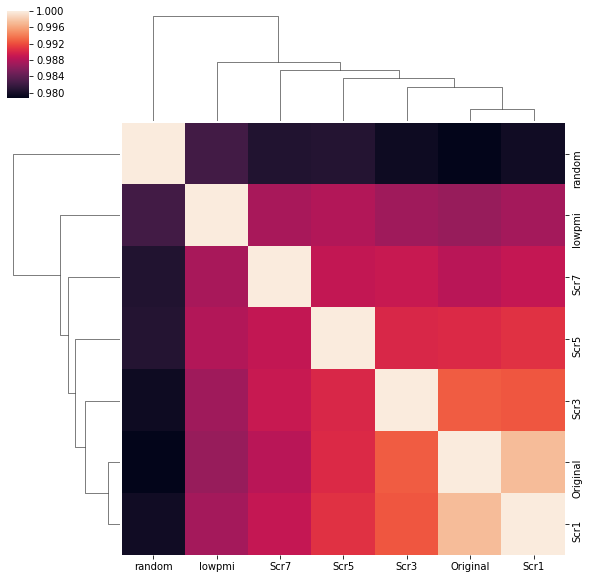

In [14]:
#sns.heatmap(df.corr())
#sns.heatmap(df.corr(method='spearman'))
sns.clustermap(df_distilgpt2.corr())

 69%|██████▊   | 8413/12265 [00:00<00:00, 82364.88it/s]

This is the layer I'm looking at:  lstm/lstm_1/control_dependency


100%|██████████| 12265/12265 [00:10<00:00, 1141.40it/s]


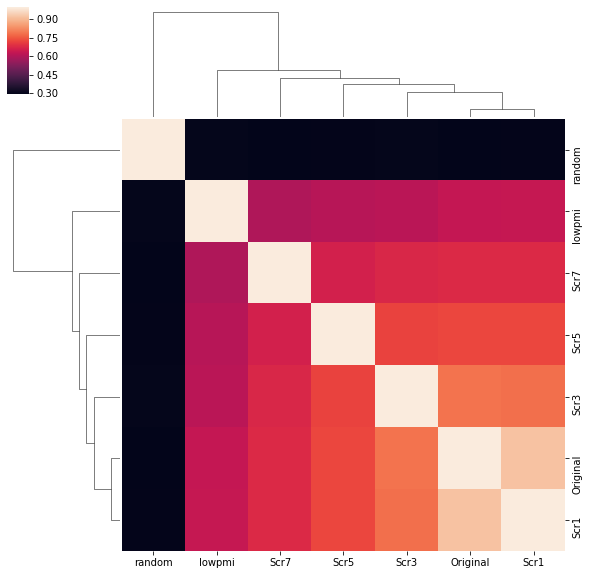

In [15]:
df_lm1b = main_df_for_plotting("lm_1b")
sns.clustermap(df_lm1b.corr())

 45%|████▌     | 5561/12265 [00:00<00:00, 53773.50it/s]

This is the layer I'm looking at:  projection


100%|██████████| 12265/12265 [00:08<00:00, 1464.52it/s]


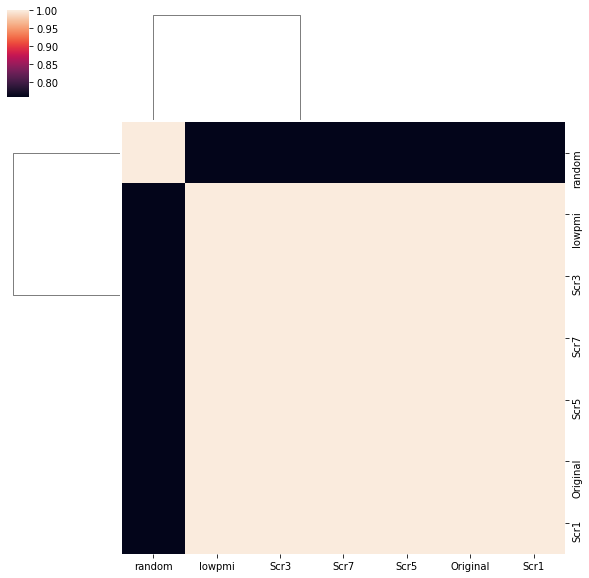

In [16]:
df_glove = main_df_for_plotting("glove")
sns.clustermap(df_glove.corr())

# 2. Look at different layers

In [17]:
df_lm1b_encoderh0 = main_df_for_plotting("distilgpt2",layer_identifier="encoder.h.0")

 34%|███▍      | 4215/12265 [00:00<00:00, 40102.06it/s]

This is the layer I'm looking at:  encoder.h.0


100%|██████████| 12265/12265 [00:10<00:00, 1209.99it/s]


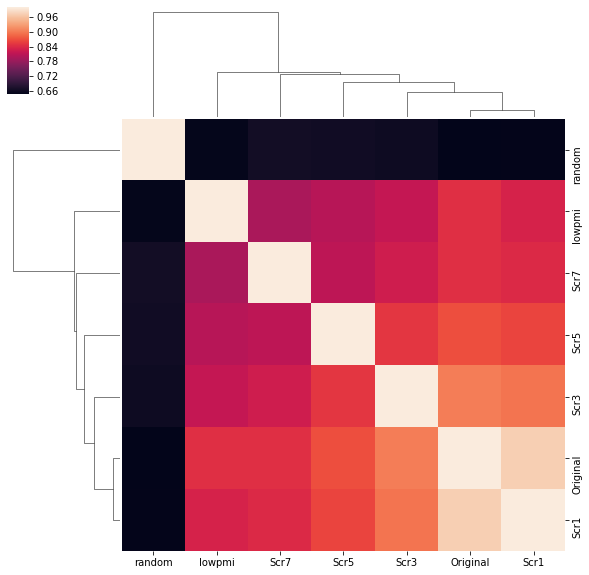

In [18]:
sns.clustermap(df_lm1b_encoderh0.corr())

In [19]:
def get_correlation_dfs_for_all_layers(model_identifier, flatten=True):
    layers = get_all_layers(model_identifier)
    df_dict = {}
    for ind,elm in enumerate(layers):
        df_dict[elm] = main_df_for_plotting(model_identifier,layer_identifier=elm,flatten=flatten)
    return df_dict

# 2.b Try looping through layers and put into subplots

### Caveat: Can't do ClusterGrid, as the graph cannot take ax as input. Look into how to do this if we want to

In [20]:
glove_correlation_dict = get_correlation_dfs_for_all_layers("glove")

 45%|████▌     | 5565/12265 [00:00<00:00, 54482.67it/s]

This is the layer I'm looking at:  projection


100%|██████████| 12265/12265 [00:06<00:00, 1828.96it/s]


In [21]:
print(len(glove_correlation_dict))

1


In [22]:
lm1b_correlation_dict = get_correlation_dfs_for_all_layers("lm_1b")

 69%|██████▊   | 8417/12265 [00:00<00:00, 82443.30it/s]

This is the layer I'm looking at:  lstm/lstm_0/control_dependency


 69%|██████▊   | 8417/12265 [00:00<00:00, 83469.77it/s]

This is the layer I'm looking at:  lstm/lstm_1/control_dependency


100%|██████████| 12265/12265 [00:08<00:00, 1526.42it/s]


In [23]:
print(len(lm1b_correlation_dict))

2


In [24]:
import math
import matplotlib.pyplot as plt

def get_subplots(dictionary,model_name):
    number_subplots = len(dictionary)
    number_rows = math.ceil(number_subplots/2)
    
    fig, ax = plt.subplots(number_rows,2, figsize=(15, 7*number_rows))
    ax = ax.flatten()
    fig.suptitle(model_name, fontsize=26)
    
    counter = 0
    for key, value in dictionary.items():
        ax[counter] = sns.heatmap(value.corr(), ax=ax[counter], square=True)
        ax[counter].set_title(key, fontsize=16)
        bottom, top = ax[counter].get_ylim()
        ax[counter].set_ylim(bottom + 0.5, top - 0.5)
        counter += 1
    if number_subplots%2 == 1:
        fig.delaxes(ax[counter])

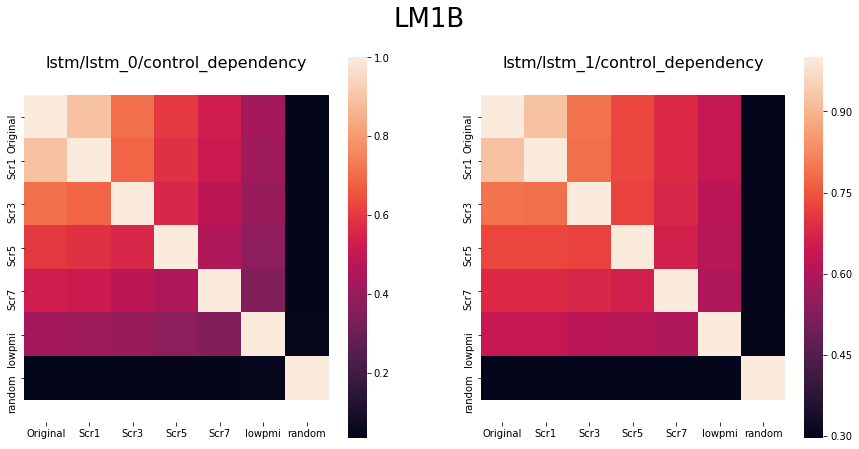

In [25]:
get_subplots(lm1b_correlation_dict, "LM1B")

# DistilGPT2

In [26]:
distilgpt2_correlation_dict = get_correlation_dfs_for_all_layers("distilgpt2")

 34%|███▍      | 4215/12265 [00:00<00:00, 40475.18it/s]

This is the layer I'm looking at:  drop


 34%|███▍      | 4215/12265 [00:00<00:00, 41371.11it/s]

This is the layer I'm looking at:  encoder.h.0


 34%|███▍      | 4214/12265 [00:00<00:00, 41754.78it/s]

This is the layer I'm looking at:  encoder.h.1


 34%|███▍      | 4215/12265 [00:00<00:00, 40804.01it/s]

This is the layer I'm looking at:  encoder.h.2


 34%|███▍      | 4215/12265 [00:00<00:00, 40637.16it/s]

This is the layer I'm looking at:  encoder.h.3


 34%|███▍      | 4215/12265 [00:00<00:00, 40947.95it/s]

This is the layer I'm looking at:  encoder.h.4


 34%|███▍      | 4215/12265 [00:00<00:00, 40512.84it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 12265/12265 [00:09<00:00, 1241.27it/s]


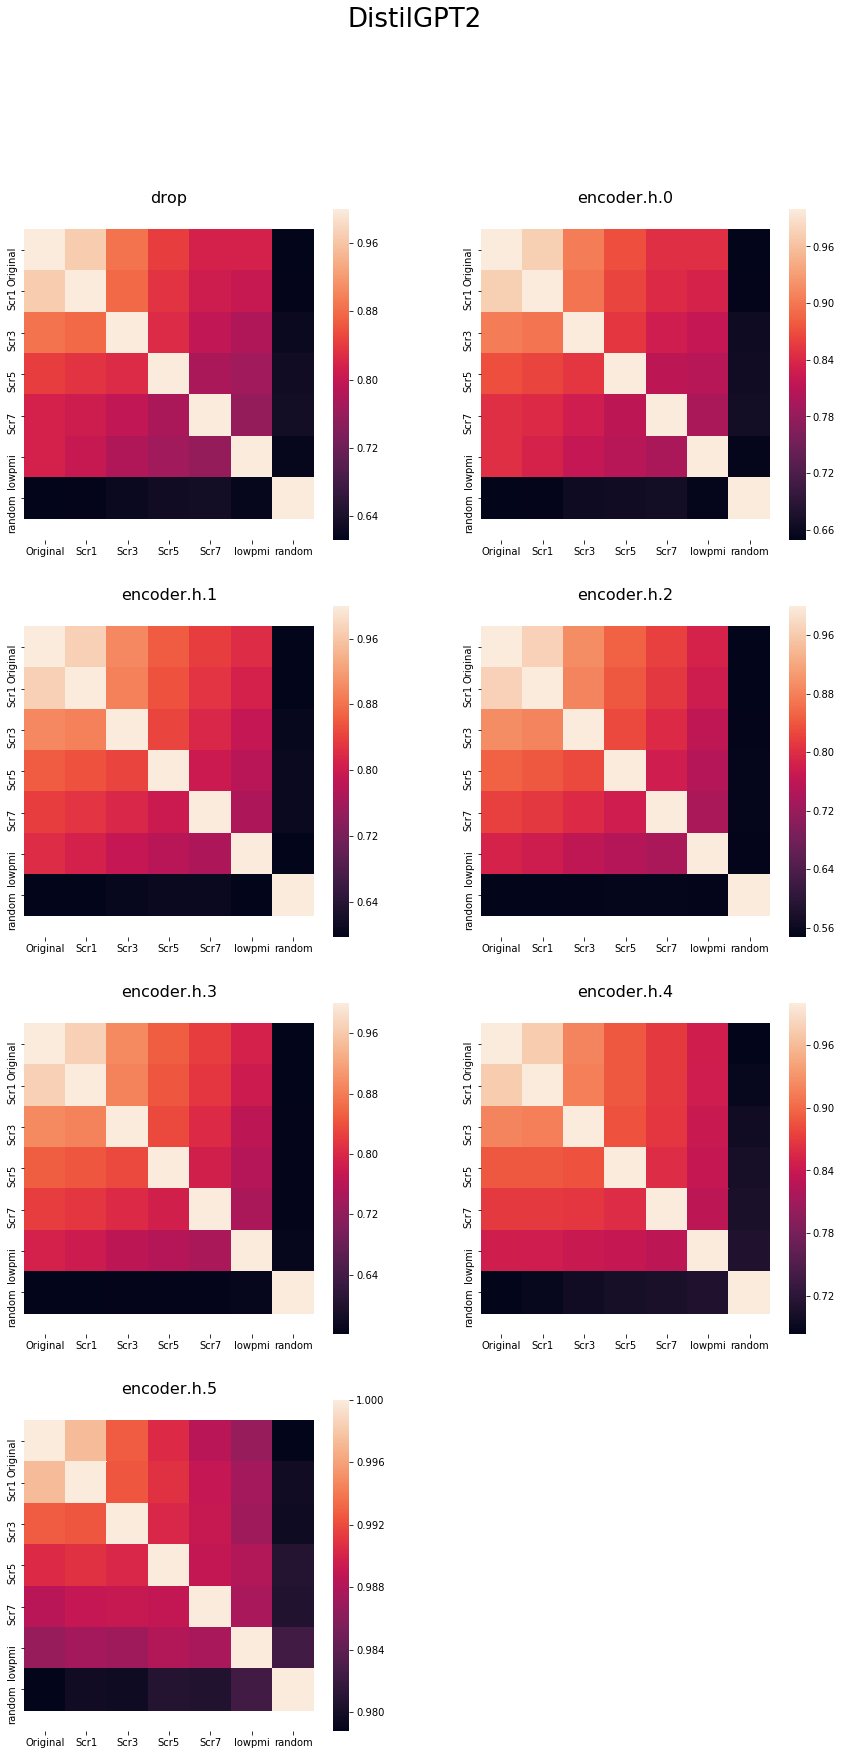

In [27]:
get_subplots(distilgpt2_correlation_dict, "DistilGPT2")

### Glove

 45%|████▌     | 5564/12265 [00:00<00:00, 54771.91it/s]

This is the layer I'm looking at:  projection


100%|██████████| 12265/12265 [00:06<00:00, 1821.24it/s]


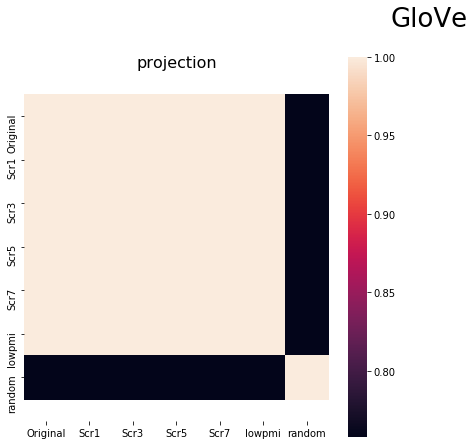

In [28]:
glove_correlation_dict = get_correlation_dfs_for_all_layers("glove")
get_subplots(glove_correlation_dict, "GloVe")

## GPT2

 56%|█████▌    | 6898/12265 [00:00<00:00, 63231.87it/s]

This is the layer I'm looking at:  drop


 56%|█████▋    | 6900/12265 [00:00<00:00, 65075.64it/s]

This is the layer I'm looking at:  encoder.h.0


 56%|█████▋    | 6900/12265 [00:00<00:00, 64058.85it/s]

This is the layer I'm looking at:  encoder.h.1


 56%|█████▋    | 6900/12265 [00:00<00:00, 66581.16it/s]

This is the layer I'm looking at:  encoder.h.2


 56%|█████▋    | 6900/12265 [00:00<00:00, 64549.77it/s]

This is the layer I'm looking at:  encoder.h.3


 56%|█████▋    | 6900/12265 [00:00<00:00, 64986.35it/s]

This is the layer I'm looking at:  encoder.h.4


 56%|█████▋    | 6900/12265 [00:00<00:00, 64260.40it/s]

This is the layer I'm looking at:  encoder.h.5


 56%|█████▋    | 6900/12265 [00:00<00:00, 65847.34it/s]

This is the layer I'm looking at:  encoder.h.6


 56%|█████▋    | 6900/12265 [00:00<00:00, 63755.16it/s]

This is the layer I'm looking at:  encoder.h.7


 56%|█████▋    | 6900/12265 [00:00<00:00, 65432.43it/s]

This is the layer I'm looking at:  encoder.h.8


 56%|█████▋    | 6900/12265 [00:00<00:00, 64238.00it/s]

This is the layer I'm looking at:  encoder.h.9


 56%|█████▋    | 6900/12265 [00:00<00:00, 65773.71it/s]

This is the layer I'm looking at:  encoder.h.10


 56%|█████▋    | 6900/12265 [00:00<00:00, 64059.41it/s]

This is the layer I'm looking at:  encoder.h.11


100%|██████████| 12265/12265 [00:13<00:00, 877.48it/s] 


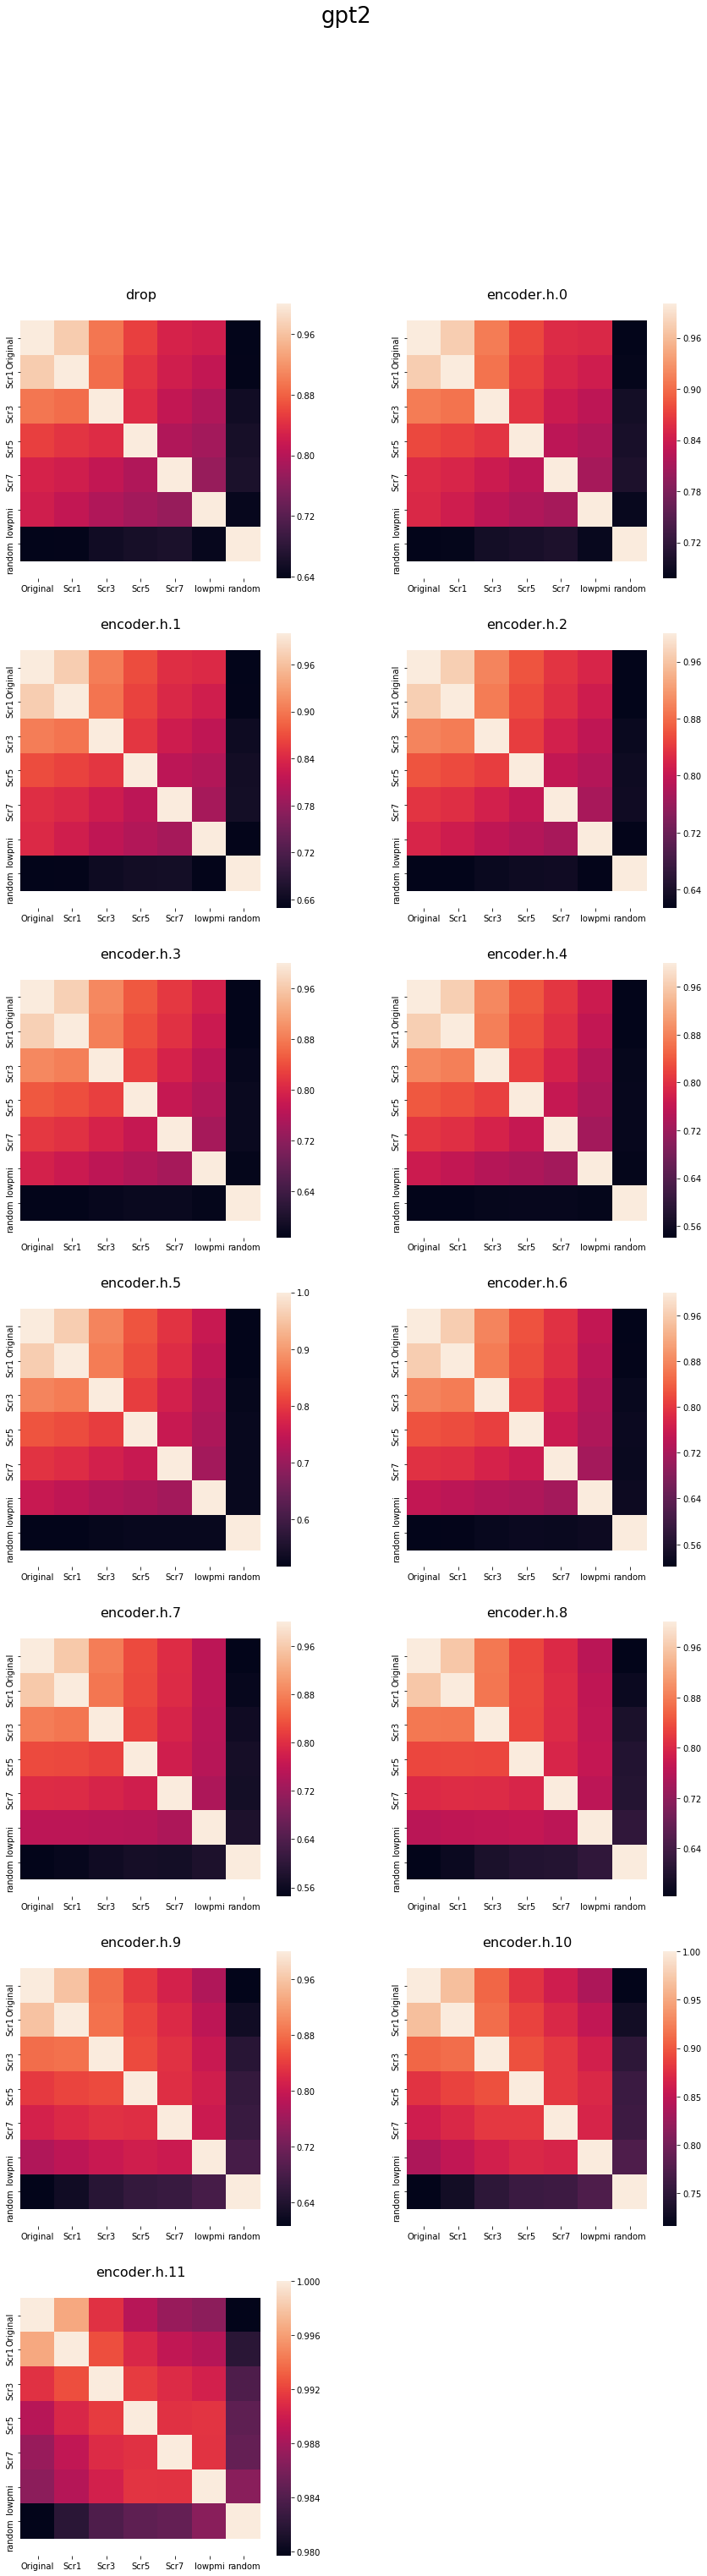

In [29]:
gpt2_correlation_dict = get_correlation_dfs_for_all_layers("gpt2")
get_subplots(gpt2_correlation_dict, "gpt2")

___________________________
___________________________
# CKA

In [30]:
from pathlib import Path

In [31]:
df_distilgpt2

,Original,Scr1,Scr3,Scr5,Scr7,lowpmi,random
0,0.074908,0.086076,-0.098503,0.287310,-0.491648,-0.268378,-0.133560
1,0.433372,0.372021,0.490790,0.501052,0.179898,0.052124,0.831461
2,-1.386395,-0.923225,-1.318906,-1.023111,-1.841627,-0.765052,-1.747107
3,-0.021115,-0.067918,0.020265,0.320247,0.128362,0.136439,-0.122085
4,0.308469,0.072625,0.104190,-0.000543,-0.236029,-0.456595,-0.441237
...,...,...,...,...,...,...,...
481531,0.419296,0.450490,0.457113,0.323549,0.027656,0.556965,0.466709
481532,0.127783,0.127696,0.186835,0.246898,0.319570,0.208378,-0.264907
481533,0.345713,0.312569,0.200625,0.350046,-0.075820,0.456372,0.071377
481534,-0.232706,-0.095448,0.158781,0.107765,-0.005065,0.058816,-0.081075


In [32]:
(Path(os.path.dirname(os.getcwd())))

PosixPath('/om/user/gretatu/neural-nlp/neural_nlp/analyze')

In [33]:
os.chdir('/om/user/gretatu/CKA-Centered-Kernel-Alignment')

In [34]:
import cca_core
from CKA import linear_CKA, kernel_CKA

In [35]:
dfmatrix_distilgpt2 = main_df_for_plotting("distilgpt2", flatten=False)

 34%|███▍      | 4215/12265 [00:00<00:00, 40761.02it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 12265/12265 [00:09<00:00, 1236.35it/s]


In [36]:
np.shape(dfmatrix_distilgpt2['Original'])

(627, 768)

In [37]:
dfmatrix_distilgpt2_h0 = main_df_for_plotting("distilgpt2", layer_identifier="encoder.h.0", flatten=False)

 34%|███▍      | 4215/12265 [00:00<00:00, 40565.26it/s]

This is the layer I'm looking at:  encoder.h.0


100%|██████████| 12265/12265 [00:09<00:00, 1270.74it/s]


In [38]:
def computeCKA(d, cka_type='linear'):
    labels = []
    
    M = np.zeros((len(d), len(d)))
    r = 0
    for k,v in d.items():
        # print(k)
        c = 0
        for k2,v2 in d.items():
            # print(k2)
            if cka_type == 'linear':
                M[r,c] = linear_CKA(np.asarray(v).T, np.asarray(v2).T)
            c += 1

        r += 1
        
        labels.append(k)
        
    return M, labels

In [39]:
lm1b_correlation_dict = get_correlation_dfs_for_all_layers("lm_1b", flatten=False)

 69%|██████▊   | 8417/12265 [00:00<00:00, 79341.63it/s]

This is the layer I'm looking at:  lstm/lstm_0/control_dependency


 69%|██████▊   | 8416/12265 [00:00<00:00, 80996.91it/s]

This is the layer I'm looking at:  lstm/lstm_1/control_dependency


100%|██████████| 12265/12265 [00:08<00:00, 1508.95it/s]


In [40]:
distilgpt2_matrix_correlation_dict = get_correlation_dfs_for_all_layers("distilgpt2", flatten=False)

 34%|███▍      | 4214/12265 [00:00<00:00, 41603.42it/s]

This is the layer I'm looking at:  drop


 34%|███▍      | 4215/12265 [00:00<00:00, 40300.79it/s]

This is the layer I'm looking at:  encoder.h.0


 34%|███▍      | 4215/12265 [00:00<00:00, 40349.36it/s]

This is the layer I'm looking at:  encoder.h.1


 34%|███▍      | 4215/12265 [00:00<00:00, 40550.75it/s]

This is the layer I'm looking at:  encoder.h.2


 34%|███▍      | 4215/12265 [00:00<00:00, 39621.40it/s]

This is the layer I'm looking at:  encoder.h.3


 34%|███▍      | 4215/12265 [00:00<00:00, 40461.84it/s]

This is the layer I'm looking at:  encoder.h.4


 34%|███▍      | 4215/12265 [00:00<00:00, 40734.25it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 12265/12265 [00:09<00:00, 1270.57it/s]


In [41]:
def get_CKA_subplots(dictionary,model_name):
    number_subplots = len(dictionary)
    number_rows = math.ceil(number_subplots/2)
    
    fig, ax = plt.subplots(number_rows,2, figsize=(15, 7*number_rows))
    ax = ax.flatten()
    fig.suptitle(model_name, fontsize=26)
    
    counter = 0
    for key, value in dictionary.items():
        # Compute CKA for each item
#        print(np.shape(value))
        cka, labels = computeCKA(value)
        print(labels)
        labels = labels[:8]
        ax[counter] = sns.heatmap(cka, ax=ax[counter], square=True, xticklabels=labels, yticklabels=labels)
        ax[counter].set_title(key, fontsize=16)
        bottom, top = ax[counter].get_ylim()
        ax[counter].set_ylim(bottom + 0.5, top - 0.5)
        counter += 1
        
    if number_subplots%2 == 1:
        fig.delaxes(ax[counter])


['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']


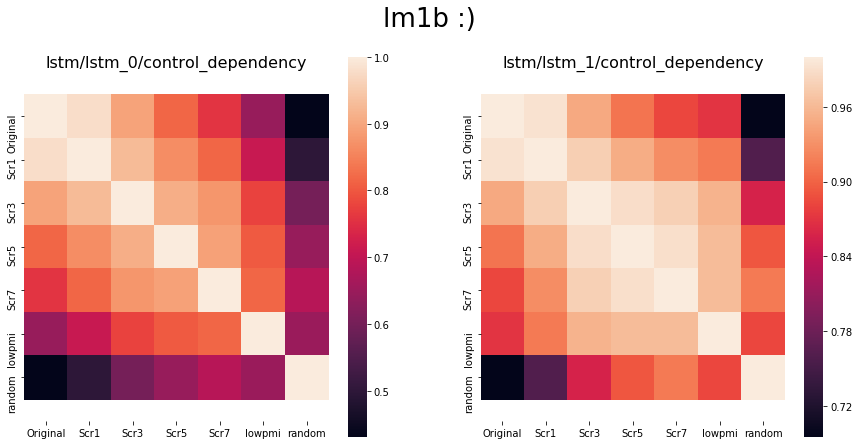

In [42]:
v=get_CKA_subplots(lm1b_correlation_dict, 'lm1b :)')

In [44]:
distilgpt_correlation_dict = get_correlation_dfs_for_all_layers("distilgpt2", flatten=False)

 34%|███▍      | 4214/12265 [00:00<00:00, 41291.05it/s]

This is the layer I'm looking at:  drop


 34%|███▍      | 4208/12265 [00:00<00:00, 40036.18it/s]

This is the layer I'm looking at:  encoder.h.0


 34%|███▍      | 4215/12265 [00:00<00:00, 40460.17it/s]

This is the layer I'm looking at:  encoder.h.1


 34%|███▍      | 4214/12265 [00:00<00:00, 42134.01it/s]

This is the layer I'm looking at:  encoder.h.2


 34%|███▍      | 4215/12265 [00:00<00:00, 40282.89it/s]

This is the layer I'm looking at:  encoder.h.3


 34%|███▍      | 4215/12265 [00:00<00:00, 40394.44it/s]

This is the layer I'm looking at:  encoder.h.4


 34%|███▍      | 4215/12265 [00:00<00:00, 40346.23it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 12265/12265 [00:09<00:00, 1293.22it/s]


['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']


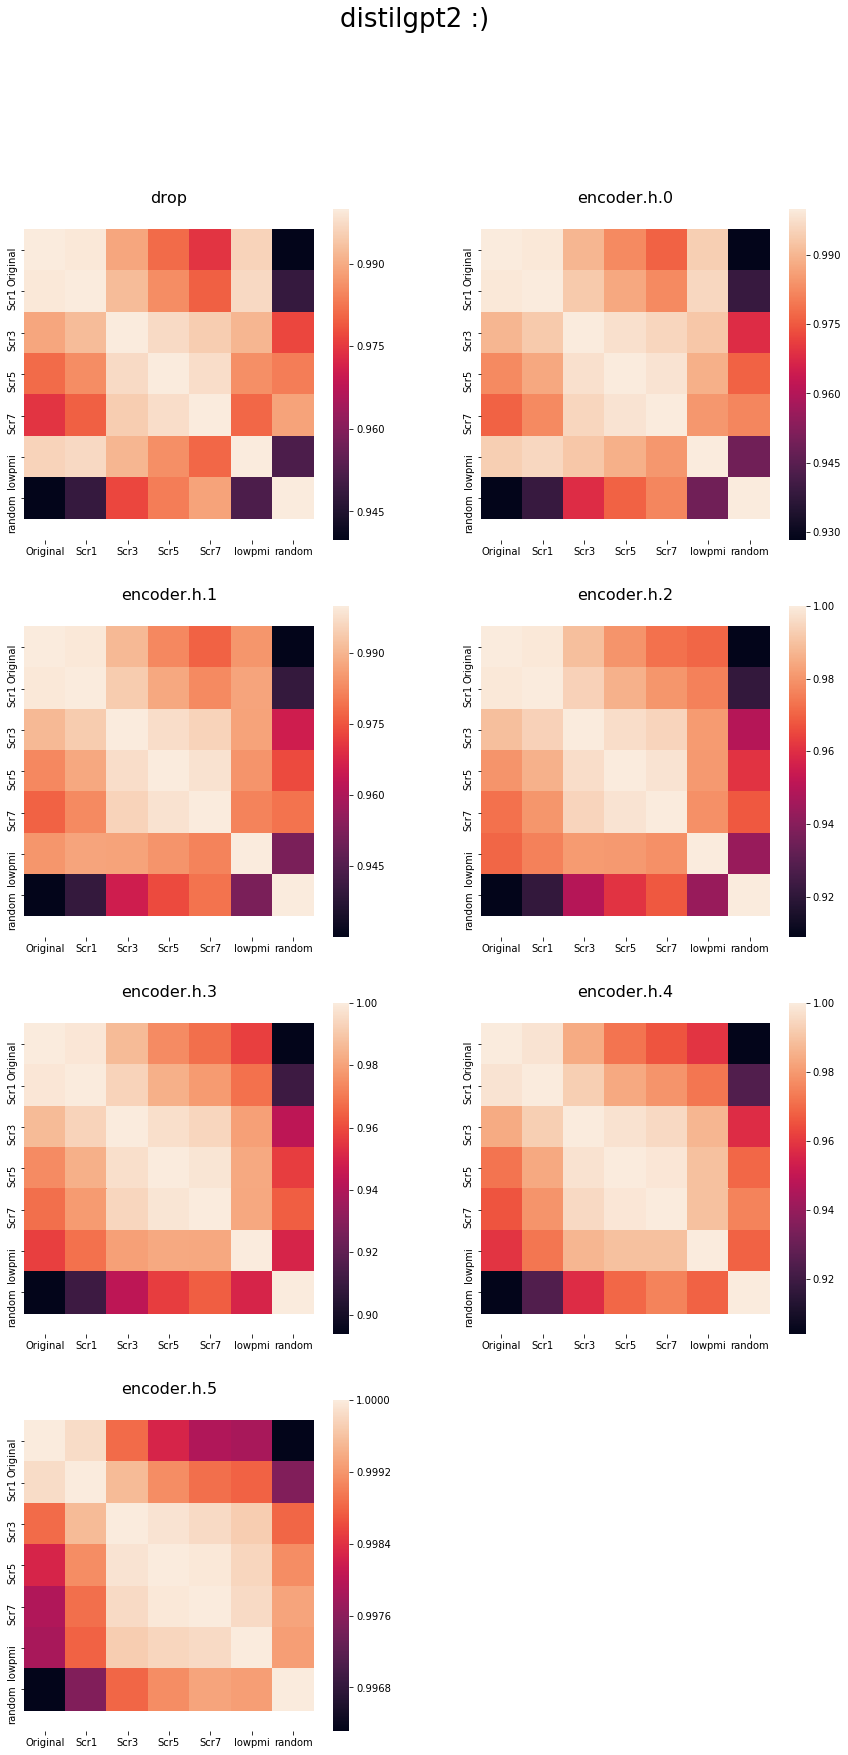

In [45]:
v=get_CKA_subplots(distilgpt_correlation_dict, 'distilgpt2 :)')

 11%|█         | 1350/12265 [00:00<00:00, 12002.40it/s]

This is the layer I'm looking at:  embedding


 11%|█         | 1351/12265 [00:00<00:00, 11560.33it/s]

This is the layer I'm looking at:  encoder.layer.0.output


 11%|█         | 1351/12265 [00:00<00:00, 11443.32it/s]

This is the layer I'm looking at:  encoder.layer.1.output


 11%|█         | 1351/12265 [00:00<00:00, 11516.49it/s]

This is the layer I'm looking at:  encoder.layer.10.output


 11%|█         | 1351/12265 [00:00<00:00, 11889.86it/s]

This is the layer I'm looking at:  encoder.layer.11.output


 11%|█         | 1351/12265 [00:00<00:00, 11608.86it/s]

This is the layer I'm looking at:  encoder.layer.12.output


 11%|█         | 1351/12265 [00:00<00:00, 11951.12it/s]

This is the layer I'm looking at:  encoder.layer.13.output


 11%|█         | 1351/12265 [00:00<00:00, 11679.06it/s]

This is the layer I'm looking at:  encoder.layer.14.output


 11%|█         | 1351/12265 [00:00<00:00, 12018.65it/s]

This is the layer I'm looking at:  encoder.layer.15.output


 11%|█         | 1351/12265 [00:00<00:00, 11745.39it/s]

This is the layer I'm looking at:  encoder.layer.16.output


 11%|█         | 1351/12265 [00:00<00:00, 11774.78it/s]

This is the layer I'm looking at:  encoder.layer.17.output


 11%|█         | 1351/12265 [00:00<00:00, 11699.85it/s]

This is the layer I'm looking at:  encoder.layer.18.output


 11%|█         | 1351/12265 [00:00<00:00, 11900.10it/s]

This is the layer I'm looking at:  encoder.layer.19.output


 11%|█         | 1351/12265 [00:00<00:00, 11527.97it/s]

This is the layer I'm looking at:  encoder.layer.2.output


 11%|█         | 1350/12265 [00:00<00:00, 13432.41it/s]

This is the layer I'm looking at:  encoder.layer.20.output


 11%|█         | 1351/12265 [00:00<00:00, 11671.19it/s]

This is the layer I'm looking at:  encoder.layer.21.output


 11%|█         | 1351/12265 [00:00<00:00, 11987.00it/s]

This is the layer I'm looking at:  encoder.layer.22.output


 11%|█         | 1351/12265 [00:00<00:00, 11746.02it/s]

This is the layer I'm looking at:  encoder.layer.23.output


 11%|█         | 1351/12265 [00:00<00:00, 11786.97it/s]

This is the layer I'm looking at:  encoder.layer.3.output


 11%|█         | 1351/12265 [00:00<00:00, 11934.13it/s]

This is the layer I'm looking at:  encoder.layer.4.output


 11%|█         | 1351/12265 [00:00<00:00, 11595.63it/s]

This is the layer I'm looking at:  encoder.layer.5.output


 11%|█         | 1351/12265 [00:00<00:00, 11491.52it/s]

This is the layer I'm looking at:  encoder.layer.6.output


 11%|█         | 1351/12265 [00:00<00:00, 11862.33it/s]

This is the layer I'm looking at:  encoder.layer.7.output


 11%|█         | 1351/12265 [00:00<00:00, 11638.19it/s]

This is the layer I'm looking at:  encoder.layer.8.output


 11%|█         | 1351/12265 [00:00<00:00, 11989.76it/s]

This is the layer I'm looking at:  encoder.layer.9.output


100%|██████████| 12265/12265 [00:25<00:00, 473.14it/s] 


['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'lowpmi', 'random']
['Original', 'Scr1', 'Scr

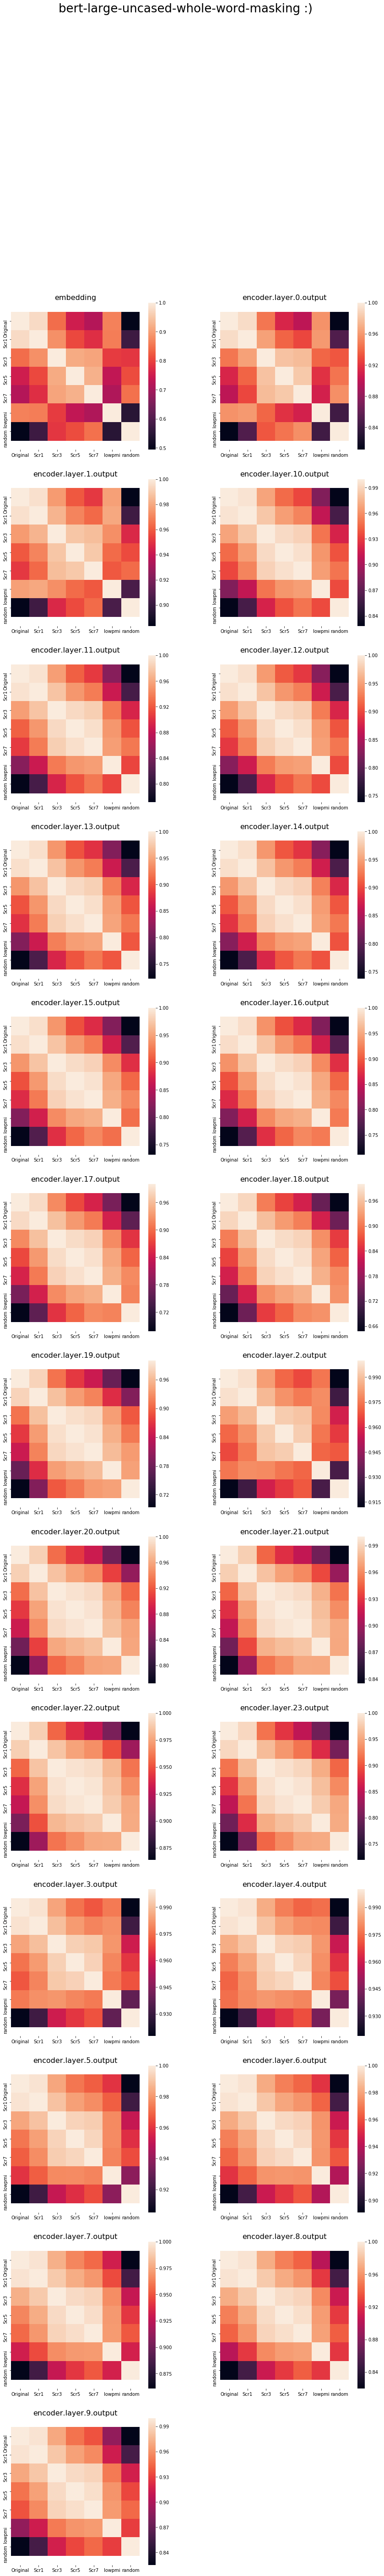

In [46]:
bert_correlation_dict = get_correlation_dfs_for_all_layers("bert-large-uncased-whole-word-masking", flatten=False)
v=get_CKA_subplots(bert_correlation_dict, 'bert-large-uncased-whole-word-masking :)')